# Train and Test clasic models arquitectures

In [1]:
# libraries importing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# additional modules
import sys
sys.path.append('..\Algoritmos')

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Cargar la data

In [2]:
path_to_data = '../data/'

all_files=[]
import os
for root, dirs, files in os.walk(path_to_data):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

In [3]:
# datasets with anomalies loading
all_fault_data = [pd.read_csv(file, 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True) for file in all_files if 'anomaly-free' not in file]
# anomaly-free df loading
anomaly_free_df = pd.read_csv([file for file in all_files if 'anomaly-free' in file][0], 
                            sep=';', 
                            index_col='datetime', 
                            parse_dates=True)

other_df = all_fault_data[0:15]
valve1_df = all_fault_data[15:31]
valve2_df = all_fault_data[31:36]

test_list = other_df[:2] + valve1_df[:2] + valve2_df[:2]

In [5]:
print('SKAB v0.9')
print(f'- A number of datasets: {len(all_fault_data)}')
print(f'- Shape of the random dataset: {all_fault_data[10].shape}')
n_cp = sum([len(df[df.changepoint==1.]) for df in all_fault_data])
n_outlier = sum([len(df[df.anomaly==1.]) for df in all_fault_data])
print(f'- A number of changepoints: {n_cp}')
print(f'- A number of outliers (point anomalies): {n_outlier}\n')
print(f'Head of the random dataset:')
display(all_fault_data[0].head(1))

SKAB v0.9
- A number of datasets: 34
- Shape of the random dataset: (1147, 10)
- A number of changepoints: 129
- A number of outliers (point anomalies): 13067

Head of the random dataset:


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-01 15:44:06,0.082065,0.133521,1.27794,0.054711,92.2562,22.2577,209.639,76.0197,0.0,0.0


## Inicializar Modelos

In [6]:
from LSTM_AE import LSTM_AE 
from Isolation_Forest import Isolation_Forest
from Elliptic_Envelope import Elliptic_Envelope
from utils_functions import graficar_matriz_confusion
from sklearn.preprocessing import StandardScaler
import numpy as np

In [7]:
# Elliptive_Envelope params
PARAMS = {'support_fraction': 0.9, 'contamination': 0.1, 'random_state': 42}

# model defining
ELLiptic_envelope_model = Elliptic_Envelope(PARAMS)

# hyperparameters selection
random_state=0
n_jobs=-1
contamination=0.0005
PARAMS = [random_state, n_jobs, contamination]
Isolation_forest_model = Isolation_Forest(PARAMS)

In [20]:
%%time
# inference
list_of_df = test_list
model = Isolation_forest_model
predicted_outlier, predicted_cp = [], []
for df in list_of_df:
    X_train = df[:400].drop(['anomaly','changepoint'], axis=1)
    
    # classifier fitting
    model.fit(X_train)

    # results predicting
    prediction = pd.Series(model.predict(df.drop(['anomaly','changepoint'], axis=1))*-1, 
                                index=df.index).rolling(3).median().fillna(0).replace(-1,0)
    
    # predicted outliers saving
    predicted_outlier.append(prediction)
    
    # predicted CPs saving
    prediction_cp = prediction.rolling(30).max().fillna(0).diff().abs()
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

CPU times: total: 391 ms
Wall time: 1.2 s


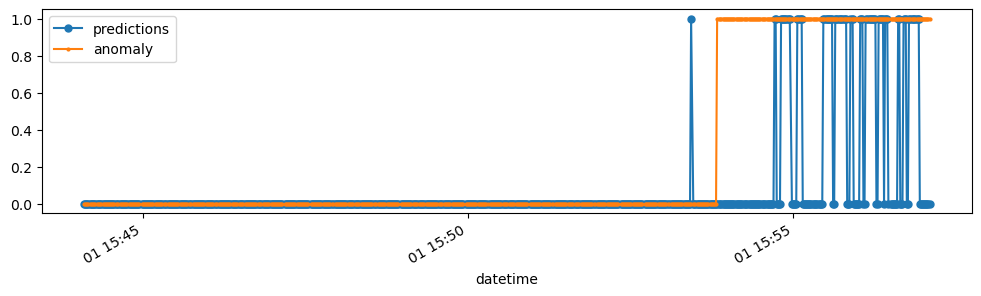

In [21]:
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

predicted_outlier[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_outlier[0].plot(marker='o', markersize=2)
plt.legend();

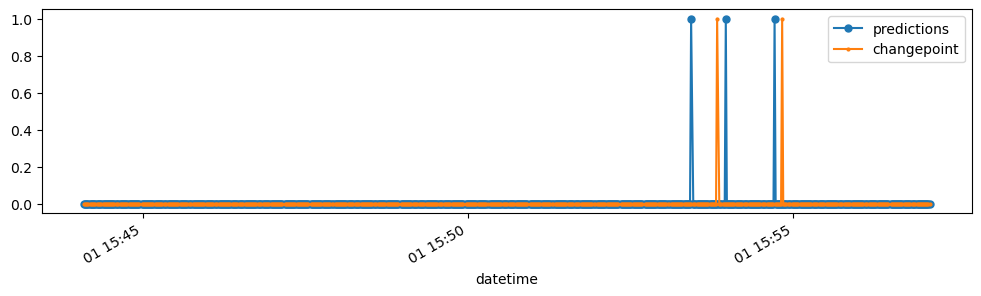

In [22]:
# true changepoint indices selection
true_cp = [df.changepoint for df in list_of_df]

predicted_cp[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend();

## Métricas

In [23]:
from tsad.evaluating.evaluating import evaluating

In [24]:
# binary classification metrics calculation
binary = evaluating(
    true_outlier, 
    predicted_outlier, 
    metric='binary'
)

Since you not choose numenta_time and portion, then portion will be 0.1
False Alarm Rate 1.72 %
Missing Alarm Rate 79.31 %
F1 metric 0.33


Since you not choose numenta_time and portion, then portion will be 0.1
TP 477
TN 4177
FP 73
FN 1828


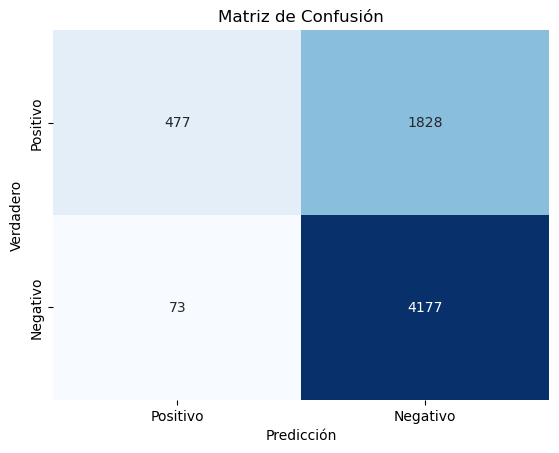

In [25]:
conf_matrix = evaluating(
    true_outlier, 
    predicted_outlier, 
    metric='confusion_matrix'
)
graficar_matriz_confusion(conf_matrix)

In [26]:
# average detection delay metric calculation
add = evaluating(
    true_cp, 
    predicted_cp, 
    metric='average_time',
    anomaly_window_destenation='righter', 
    portion=1
)

Intersection of scoring windows(Timestamp('2020-03-01 15:58:10'), Timestamp('2020-03-01 15:54:50'))
Intersection of scoring windows(Timestamp('2020-02-08 18:02:23.600000'), Timestamp('2020-02-08 17:58:38'))
Intersection of scoring windows(Timestamp('2020-02-08 18:09:01.600000'), Timestamp('2020-02-08 18:08:03'))
Intersection of scoring windows(Timestamp('2020-03-09 10:48:33'), Timestamp('2020-03-09 10:45:33'))
Intersection of scoring windows(Timestamp('2020-03-09 10:54:33'), Timestamp('2020-03-09 10:51:34'))
Intersection of scoring windows(Timestamp('2020-03-09 13:48:38.800000'), Timestamp('2020-03-09 13:45:39'))
Intersection of scoring windows(Timestamp('2020-03-09 13:54:38.800000'), Timestamp('2020-03-09 13:51:39'))
Intersection of scoring windows(Timestamp('2020-03-09 16:30:30'), Timestamp('2020-03-09 16:27:30'))
Intersection of scoring windows(Timestamp('2020-03-09 16:36:32'), Timestamp('2020-03-09 16:33:31'))
Intersection of scoring windows(Timestamp('2020-03-09 16:50:30.800000'),

In [27]:
# nab metric calculation
nab = evaluating(
    true_cp, 
    predicted_cp, 
    metric='nab', 
    numenta_time='30S',
    anomaly_window_destenation='center', 
)

Standart  -  14.73
LowFP  -  6.28
LowFN  -  20.42
